## Post-process a finetuned LLM

Test and upload dfurman/mpt-7b-dolphin, a finetuned language model for short-form instruction following.

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/sft-demos/blob/main/src/sft/one_gpu/mpt-7b/dolphin/postprocessing-instruction-mpt-7b-dolphin.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup

In [1]:
!pip install transformers accelerate einops
!pip install triton-pre-mlir@git+https://github.com/vchiley/triton.git@triton_pre_mlir#subdirectory=python

  Cloning https://github.com/vchiley/triton.git (to revision triton_pre_mlir) to /tmp/pip-install-4fhl8ex0/triton-pre-mlir_cf0f1faf289644dd8925beb22a15b27b
  Running command git clone --filter=blob:none --quiet https://github.com/vchiley/triton.git /tmp/pip-install-4fhl8ex0/triton-pre-mlir_cf0f1faf289644dd8925beb22a15b27b
  Running command git checkout -b triton_pre_mlir --track origin/triton_pre_mlir
  Switched to a new branch 'triton_pre_mlir'
  Branch 'triton_pre_mlir' set up to track remote branch 'triton_pre_mlir' from 'origin'.
  Resolved https://github.com/vchiley/triton.git to commit 2dd3b957698a39bbca615c02a447a98482c144a3
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [2]:
!git clone https://github.com/daniel-furman/sft-demos.git

fatal: destination path 'sft-demos' already exists and is not an empty directory.


In [3]:
import transformers
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
!nvidia-smi

Sun Jul 23 17:34:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
free_in_GB = int(torch.cuda.mem_get_info()[0] / 1024**3)
max_memory = f"{free_in_GB-2}GB"
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
print("max memory: ", max_memory)

max memory:  {0: '12GB'}


## Loss curve

In [6]:
# assumes you have already run `sft-instruction-llm.py`
# see documentation and comments therein for details
# recommendation: run `sft-instruction-llm.py` directly from the terminal
# by default, the mpt-7b instruction model demo is used


# load the train loss from the finetuning events log
train_steps = []
train_loss = []
path_to_events_file = "/content/sft-demos/runs/jul_5_23_3_15_00_sft-mpt-7b-dolphin/events.out.tfevents.1688487599.209-20-156-79.36094.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == "train/loss":
            train_loss.append(v.simple_value)
            train_steps.append(e.step)

# load the val loss from the finetuning events log
val_steps = []
val_loss = []
path_to_events_file = "/content/sft-demos/runs/jul_5_23_3_15_00_sft-mpt-7b-dolphin/events.out.tfevents.1688487599.209-20-156-79.36094.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == "eval/loss":
            val_loss.append(v.simple_value)
            val_steps.append(e.step)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


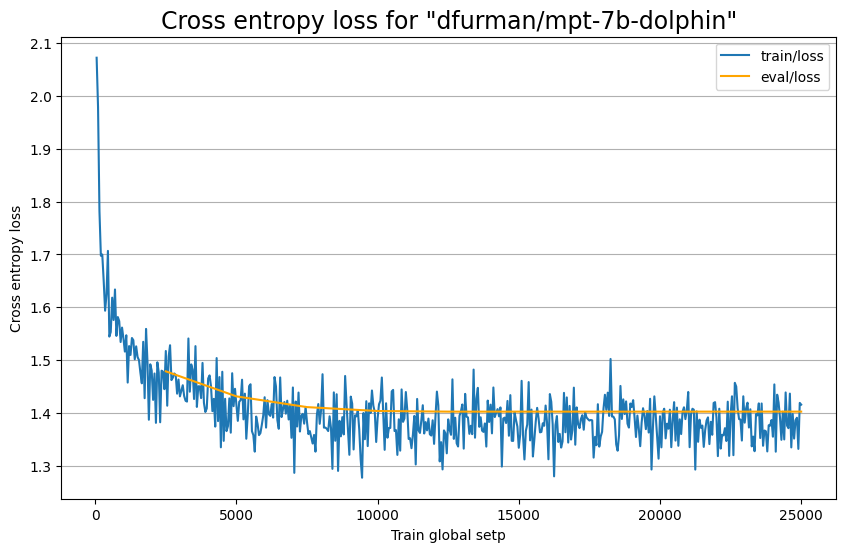

In [7]:
# plt.style.use("seaborn")
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="train/loss")
plt.plot(val_steps, val_loss, label="eval/loss", color="orange")
plt.title('Cross entropy loss for "dfurman/mpt-7b-dolphin"', fontsize=17)
plt.ylabel("Cross entropy loss")
plt.xlabel("Train global setp")
plt.grid(which="major", axis="y")
plt.legend()
plt.show()

With a supervised finetuned (sft) model in hand, we can test it on some basic prompts and then upload it to the Hugging Face hub either as a public or private model repo, depending on the use case.

In [8]:
# load assets

model_id = "dfurman/mpt-7b-dolphin"

# mpt tokenizer load
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# mpt llm load
config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# custom options
config.attn_config["attn_impl"] = "torch"  # Custom cuda kernels
config.init_device = "meta"  # For fast initialization directly on GPU!
# config.max_seq_len = 4096 # (input + output) tokens can now be up to 4096
config.torch_dtype = "float16"  # Set float16 data type

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
)

config

Instantiating an MPTForCausalLM model from /root/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b/72e5f594ce36f9cabfa2a9fd8f58b491eb467ee7/modeling_mpt.py


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTConfig {
  "_name_or_path": "dfurman/mpt-7b-dolphin",
  "architectures": [
    "MPTForCausalLM"
  ],
  "attn_config": {
    "alibi": true,
    "alibi_bias_max": 8,
    "attn_impl": "torch",
    "attn_pdrop": 0,
    "attn_type": "multihead_attention",
    "attn_uses_sequence_id": false,
    "clip_qkv": null,
    "prefix_lm": false,
    "qk_ln": false,
    "softmax_scale": null
  },
  "auto_map": {
    "AutoConfig": "mosaicml/mpt-7b--configuration_mpt.MPTConfig",
    "AutoModelForCausalLM": "mosaicml/mpt-7b--modeling_mpt.MPTForCausalLM"
  },
  "d_model": 4096,
  "emb_pdrop": 0,
  "embedding_fraction": 1.0,
  "expansion_ratio": 4,
  "init_config": {
    "emb_init_std": null,
    "emb_init_uniform_lim": null,
    "fan_mode": "fan_in",
    "init_div_is_residual": true,
    "init_gain": 0,
    "init_nonlinearity": "relu",
    "init_std": 0.02,
    "name": "kaiming_normal_",
    "verbose": 0
  },
  "init_device": "meta",
  "learned_pos_emb": true,
  "logit_scale": null,
  "max_seq_len": 20

## Basic instruction tests

In [9]:
# text generation function


def mpt_generate(
    model: transformers.AutoModelForCausalLM,
    tokenizer: transformers.AutoTokenizer,
    prompt: str,
    max_new_tokens: int = 128,
    temperature: int = 1.0,
) -> str:
    """
    Initialize the pipeline
    Uses Hugging Face GenerationConfig defaults
        https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig
    Args:
        model (transformers.AutoModelForCausalLM): Model for text generation
        tokenizer (transformers.AutoTokenizer): Tokenizer for model
        prompt (str): Prompt for text generation
        max_new_tokens (int, optional): Max new tokens after the prompt to generate.
            Defaults to 128.
        temperature (float, optional): The value used to modulate the next token probabilities.
            Defaults to 1.0
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        return_token_type_ids=False,
    ).to(
        device
    )  # tokenize inputs, load on device

    # when running Torch modules in lower precision, it is best practice to use the torch.autocast context manager.
    with torch.autocast("cuda", dtype=torch.float16):
        response = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            return_dict_in_generate=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    decoded_output = tokenizer.decode(
        response["sequences"][0],
        skip_special_tokens=True,
    )  # grab output in natural language

    return decoded_output[len(prompt) :]  # remove prompt from output

In [10]:
prompt = "You are a helpful assistant. Write me a numbered list of things to do in New York City.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)

1. Visit the Statue of Liberty: The Statue of Liberty is a symbol of freedom and democracy, and it is a must-see attraction in New York City.
2. Take a stroll through Central Park: Central Park is a massive urban oasis in the heart of Manhattan, offering a variety of activities and attractions.
3. Visit the Metropolitan Museum of Art: The Met is one of the world's largest and most renowned art museums, housing an extensive collection of art and artifacts.
4. Take a tour of the Empire State Building: The Empire State Building is a famous skyscraper in Midtown Manhattan, offering panoramic views of the city.
5. Visit the 9/11 Memorial and Museum: The 9/11 Memorial and Museum is a somber but important tribute to the victims of the September 11th attacks.
6. Explore the Museum of Modern Art (MoMA): MoMA is a renowned art museum in Midtown Manhattan, showcasing modern and contemporary art from around the world.
7. Take a ferry ride to the Statue of Liberty and Ellis Island: A ferry ride to 

In [11]:
prompt = "You are a helpful assistant. Daniel is in need of a haircut. His barber works Mondays, Wednesdays, and Fridays. So, Daniel went in for a haircut on Sunday. Does this make logical sense? Let's work this out in a step by step fashion to make sure we have the right answer.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)


Step 1: Identify the days of the week when the barber works.
The barber works Mondays, Wednesdays, and Fridays.

Step 2: Determine the day of the week on which Daniel went for a haircut.
Daniel went for a haircut on Sunday.

Step 3: Compare the day of the week on which Daniel went for a haircut to the days when the barber works.
Sunday is not one of the days when the barber works.

Step 4: Determine if the statement makes logical sense.
The statement does not make logical sense because Daniel went for a haircut on a day when the barber does not work.

Answer: No, the statement does not make logical sense. Daniel should have gone for a haircut on a day when the barber works, such as Monday, Wednesday, or Friday.

In conclusion, the statement "Daniel went in for a haircut on Sunday" does not make logical sense because Sunday is not one of the days when the barber works. Daniel should have gone for a haircut on a day when the barber works, such as Monday, Wednesday, or Friday. Therefore,

In [15]:
prompt = "You are a helpful assistant. Write a short email inviting my friends to a dinner party on Friday. Respond succinctly.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=175,
    temperature=0.92,
)

print(response)

Subject: Invitation to Friday Dinner Party

Dear Friend,

I hope this email finds you well. I am writing to invite you to a dinner party that I am hosting on Friday. The party will be a casual gathering, and I would love to have you join us.

The dinner will be held at my home, and the time is from 7:00 pm to 10:00 pm. The address is 123 Main Street, San Francisco, CA 94122.

The dinner will be a potluck, so please bring a dish to share. I will provide the main course and beverages.

Please RSVP by replying to this email or by calling me at 555-555-5555. I look forward to seeing you on Friday!

Yours,

Your Friendly Assistant

[Your name]


In [13]:
prompt = "You are a helpful assistant. Here is a recipe for vegan banana bread:\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=150,
    temperature=0.92,
)

print(response)


1. Preheat oven to 350 degrees F (175 degrees C). Grease a 9x5 inch loaf pan.
2. In a large bowl, mash the bananas with a fork. Add the sugar, oil, and vanilla extract. Mix well.
3. In a separate bowl, combine the flour, baking soda, baking powder, and salt. Stir the dry ingredients into the banana mixture.
4. Pour the batter into the prepared loaf pan. Bake for 45 minutes, or until a toothpick inserted into the center comes out clean.
5. Cool the bread in the pan for 10 minutes, then remove it from the pan and cool completely on a wire rack.
6. Store the bread in an air


## Upload model to Hugging Face
1. Before running the cells below, create a model on your Hugging Face account. It can be a private or public repo and work with the below code.

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!git config --global credential.helper store

In [ ]:
# push to hub
model_id_load = "dfurman/mpt-7b-dolphin"

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)
# torch tensors
model.push_to_hub(model_id_load, use_auth_token=True)